# Code to reproduce the experiments performed on the Zakharov function

In [ ]:
import sys
sys.path.append("..")
sys.path.append("../..")

import numpy as np
import torch
from matplotlib import pyplot as plt
from inflation import *
import json
import joblib
from numpy import arange

from mpl_toolkits.mplot3d import Axes3D
import optuna

Define the function and print the global minimum

In [2]:
n=10
i_vec = torch.arange(1,n+1)
print(i_vec)
device = 'cpu'

def zakharov(xs):
    return torch.sum(xs**2)+  (0.5*torch.sum(i_vec*xs))**2+(0.5*torch.sum(i_vec*xs))**4

global_min = torch.zeros(n)
print(zakharov(global_min))

xs = torch.tensor([1., 1., 1., 1., 1.,1.,1.,1.,1.,1.])
print("Initial value: ", zakharov(xs).item())

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
tensor(0.)
Initial value:  572680.3125


In [3]:
#common parameters
tune_iterations = 250 
n_trials = 500 
test_iterations = 14*tune_iterations

x0 = xs.tolist()
func = zakharov
F0 = 0
v0 = 1e-22

Optimization functions for each optimizer

In [4]:
def objective_ECDSep(trial):
    
    consEn = trial.suggest_categorical("consEn", [True, False])  #Categorical parameter
    deltaEn = trial.suggest_float("deltaEn", 0.0, 50)
    nu  = trial.suggest_float("nu", 1e-8, 1.0)
    lr  = trial.suggest_float("lr", 1e-2, 1e4)
    eta = trial.suggest_float("eta", 1, 4)

    xs = torch.tensor(x0)
    xs.requires_grad=True
    optimizer = ECDSep([xs], lr=lr, nu = nu, F0 = F0, deltaEn = deltaEn, consEn = consEn, eta = eta, weight_decay = 0.0)
    minloss = np.inf
    for i in range(tune_iterations):
        optimizer.zero_grad()
        loss_fn=func(xs)
        if  loss_fn.item() < minloss: 
            minloss = loss_fn.item()
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
    return minloss

def objective_GDM(trial):
    
    lr  = trial.suggest_float("lr", 1e-8, 1e-3)
    momentum = trial.suggest_float("momentum", 0.8, 1)

    xs = torch.tensor(x0)
    xs.requires_grad=True
    optimizer = torch.optim.SGD([xs], lr=lr, momentum=momentum, weight_decay = 0.0)
    minloss = np.inf
    for i in range(tune_iterations):
        optimizer.zero_grad()
        loss_fn=func(xs)
        if  loss_fn.item() < minloss: 
            minloss = loss_fn.item()
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
    return minloss

def objective_Adam(trial):
    
    lr  = trial.suggest_float("lr", 1e-2, 1e4)
    beta1 = trial.suggest_float("beta1", 0.7, 1)
    beta2 = trial.suggest_float("beta2", 0.7, 1)
    eps = trial.suggest_float("eps", 1e-12, 1e-6)

    xs = torch.tensor(x0)
    xs.requires_grad=True
    optimizer = torch.optim.Adam([xs], lr=lr, betas=(beta1, beta2), weight_decay = 0.0)
    minloss = np.inf
    for i in range(tune_iterations):
        optimizer.zero_grad()
        loss_fn=func(xs)
        if  loss_fn.item() < minloss: 
            minloss = loss_fn.item()
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
    return minloss


# function for BBI, turning off bounces
threshold0 = 1e20
n_fixed_bounces = 0
threshold = 1e25
deltaEnBBI = 0.0
def objective_BBI(trial):

    consEn = trial.suggest_categorical("consEn", [True, False])   #Categorical parameter
    lr  = trial.suggest_float("lr", 1e-4, 1e-2)

    xs = torch.tensor(x0)
    xs.requires_grad=True
    optimizer = BBI([xs], lr=lr, v0 = v0, deltaEn = deltaEnBBI, consEn = consEn, threshold0=threshold0,  threshold=threshold, n_fixed_bounces=n_fixed_bounces)
    minloss = np.inf
    for i in range(tune_iterations):
        optimizer.zero_grad()
        loss_fn=func(xs)
        if  loss_fn.item() < minloss: 
            minloss = loss_fn.item()
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
    return minloss

## Tuning for each optimizer

ECDSep

In [ ]:
study_ECDSep = optuna.create_study()
study_ECDSep.optimize(objective_ECDSep, n_trials=n_trials)
best_params_ECDSep = study_ECDSep.best_params
print(best_params_ECDSep)
joblib.dump(study_ECDSep,"optuna-zakharov-ECDSep.pkl")

GDM

In [ ]:
study_GDM = optuna.create_study()
study_GDM.optimize(objective_GDM, n_trials=n_trials)
best_params_GDM = study_GDM.best_params
print(best_params_GDM)
joblib.dump(study_GDM,"optuna-zakharov-GDM.pkl")

Adam

In [ ]:
study_Adam = optuna.create_study()
study_Adam.optimize(objective_Adam, n_trials=n_trials)
best_params_Adam = study_Adam.best_params
print(best_params_Adam)
joblib.dump(study_Adam,"optuna-zakharov-Adam.pkl")

BBI

In [ ]:
study_BBI = optuna.create_study()
study_BBI.optimize(objective_BBI, n_trials=n_trials)
best_params_BBI = study_BBI.best_params
print(best_params_BBI)
joblib.dump(study_BBI,"optuna-zakharov-BBI.pkl")

## Runs with the best hypers

In [9]:
print("Best hyperparameters for ECDSep")
print(best_params_ECDSep)

Best hyperparameters for ECDSep
{'consEn': True, 'deltaEn': 5.051214553994412, 'nu': 0.08155467868356955, 'lr': 9594.610818688134, 'eta': 1.0115627615016867}


In [11]:
print("Best hyperparameters for Adam")
print(best_params_Adam)

Best hyperparameters for Adam
{'lr': 1.2542526723690335, 'beta1': 0.7268302532453466, 'beta2': 0.9054713087941392, 'eps': 6.845169368447388e-07}


In [13]:
print("Best hyperparameters for GDM")
print(best_params_GDM)

Best hyperparameters for GDM
{'lr': 3.727912236249505e-06, 'momentum': 0.9425714481791437}


In [14]:
print("Best hyperparameters for BBI")
print(best_params_BBI)

Best hyperparameters for BBI
{'consEn': True, 'lr': 0.0026001081349641686}


Minimization with best parameters of ECDSep

In [15]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = ECDSep([xs], weight_decay = 0.0, **best_params_ECDSep, F0 = F0)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_ECDSep = losses

Minimization with best parameters of BBI

In [16]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = BBI([xs], **best_params_BBI, deltaEn = deltaEnBBI, v0 = v0, n_fixed_bounces= n_fixed_bounces, threshold= threshold, threshold0=threshold0)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_BBI = losses

Minimization with best parameters of GDM

In [17]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = torch.optim.SGD([xs], weight_decay = 0.0, **best_params_GDM)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_GDM = losses

Minimization with best parameters of Adam

In [18]:
xs = torch.tensor(x0)
xs.requires_grad=True
lr = best_params_Adam['lr']
betas = (best_params_Adam['beta1'],best_params_Adam['beta2'])
optimizer = torch.optim.Adam([xs], weight_decay = 0.0,lr = lr, betas = betas )
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_Adam = losses

Plot the results

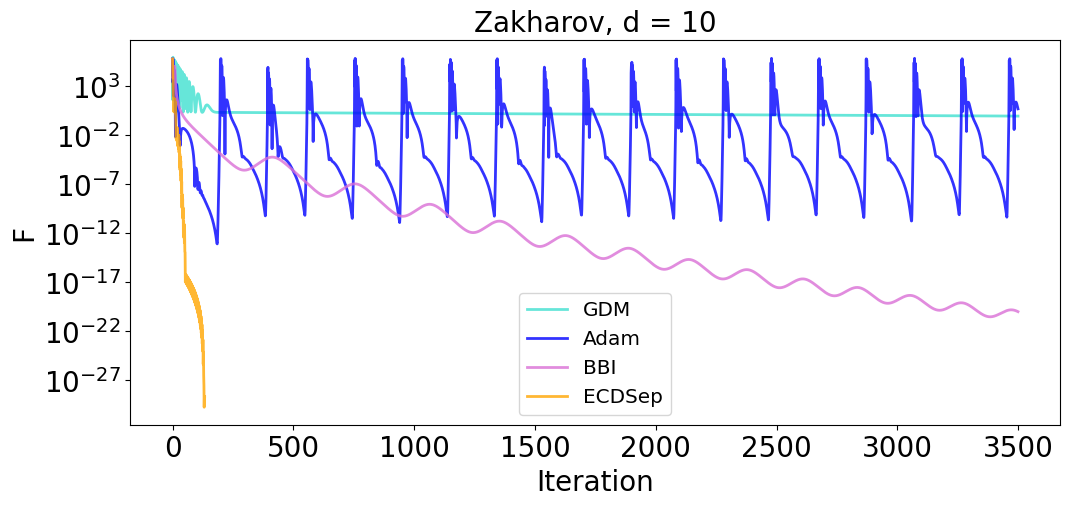

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(losses_GDM, label="GDM", alpha=.8, linewidth=2, color='turquoise')
plt.plot(losses_Adam, label="Adam", alpha = .8, linewidth=2, color='blue')
plt.plot(losses_BBI, label="BBI", alpha = .8, linewidth=2, color='orchid')
plt.plot(losses_ECDSep, label="ECDSep", alpha = .8, linewidth=2, color='orange')
#plt.plot(losses_ECDSepNoChaos, label="ECDSep No Chaos", alpha = .8, linewidth=2, color='red')
plt.title('Zakharov, d = '+str(n), fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('F', fontsize = 20)
plt.yscale('log')
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('optuna-zakharov-BBI.pdf',bbox_inches='tight')

## Different starting point

### Experiment 1

In [39]:
test_iterations = 3500
x0 = 1.5*torch.rand(10)

ECDSep

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = ECDSep([xs], weight_decay = 0.0, **best_params_ECDSep)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_ECDSep = losses

BBI

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = BBI([xs], **best_params_BBI, v0 = v0, n_fixed_bounces= n_fixed_bounces, threshold= threshold, threshold0=threshold0)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_BBI = losses

GDM

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = torch.optim.SGD([xs], weight_decay = 0.0, **best_params_GDM)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_GDM = losses

Adam

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
lr = best_params_Adam['lr']
betas = (best_params_Adam['beta1'],best_params_Adam['beta2'])
optimizer = torch.optim.Adam([xs], weight_decay = 0.0, lr = lr, betas = betas )
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_Adam = losses

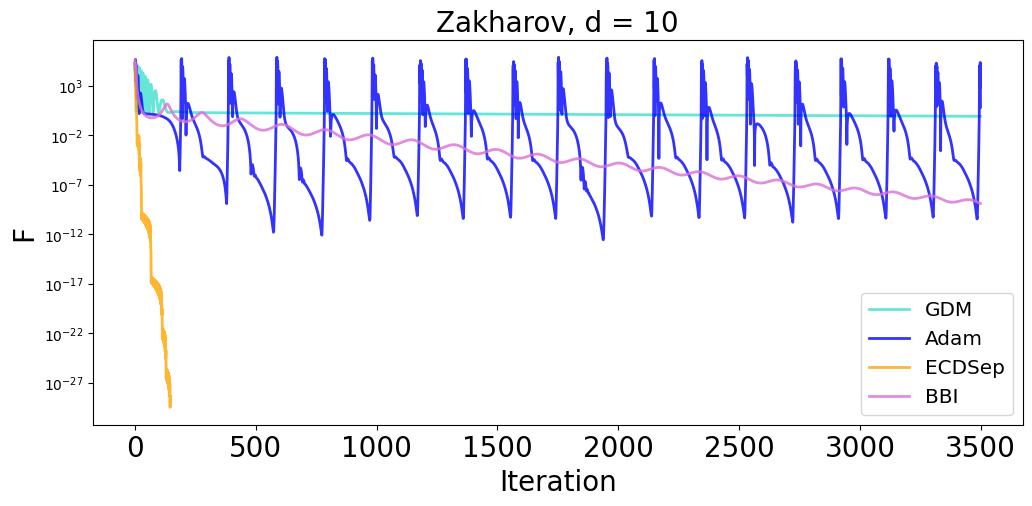

In [43]:
plt.figure(figsize=(12, 5))
plt.plot(losses_GDM, label="GDM", alpha=.8, linewidth=2, color='turquoise')
plt.plot(losses_Adam, label="Adam", alpha = .8, linewidth=2, color='blue')
plt.plot(losses_ECDSep, label="ECDSep", alpha = .8, linewidth=2, color='orange')
plt.plot(losses_BBI, label="BBI", alpha = .8, linewidth=2, color='orchid')
plt.title('Zakharov, d = '+str(n), fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('F', fontsize = 20)
plt.yscale('log')
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.xticks(fontsize = 20)
plt.savefig('optuna-zakharov.pdf',bbox_inches='tight')